In [80]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TransformerConv
from torch.nn import LSTM

In [81]:
# read from dataset of csv files
import pandas as pd
dataset0 = pd.read_csv('Dataset0.csv')
dataset1 = pd.read_csv('Dataset1.csv')
dataset2 = pd.read_csv('Dataset2.csv')

print(dataset0.shape)
print(dataset1.shape)
print(dataset2.shape)

# convert datasets to list
dataset0 = dataset0.iloc[:, 2:6].values.tolist()
dataset1 = dataset1.iloc[:, 2:6].values.tolist()
dataset2 = dataset2.iloc[:, 2:6].values.tolist()

print(type(dataset0[0][0]))


# for i in range(8092):
#     date = dataset2.iloc[i, 1]
#     hour = dataset2.iloc[i, 2]

#     if dataset0.iloc[i, 1] != date or dataset0.iloc[i, 2] != hour:
#         print('error1: ', i, ' ', date, ' ', hour, ' ', dataset0.iloc[i, [1,2]])
#         print('---------------------------------')
#     if dataset1.iloc[i, 1] != date or dataset1.iloc[i, 2] != hour:
#         print('error2: ', i, ' ', date, ' ', hour, ' ', dataset1.iloc[i, [1,2]])
#         print('---------------------------------')

#     # print(i, date, hour)

# print(dataset0.iloc[0, 2:6])

# tensors
# node1 = torch.tensor(dataset0.iloc[:, 2:6].values, dtype=torch.float)
# node2 = torch.tensor(dataset1.iloc[:, 2:6].values, dtype=torch.float)
# node3 = torch.tensor(dataset2.iloc[:, 2:6].values, dtype=torch.float)

# print(node1.shape, node2.shape, node3.shape)

(73, 5)
(73, 5)
(73, 5)
<class 'float'>


In [82]:
from torch_geometric.data import Data

num_nodes = 3
# num_timesteps = 348
num_features = 3

x = torch.tensor([dataset0, dataset1, dataset2], dtype=torch.float)
print(x.shape)

edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                            [1, 2, 0, 2, 0, 1]])

data = x

torch.manual_seed(100)

torch.Size([3, 73, 3])


In [83]:
# Define your GCNConv layer with 3 input features and 12 output features
# input features are n*m matrix, n is the number of nodes, m is the number of features
gcn1 = GCNConv(3, 6)

gcn2 = GCNConv(6, 12)

gcn3 = GCNConv(12, 12)

# Define your TransformerConv layer with 12 input features and 3 output features:
transformer = TransformerConv(12, 1, heads=3, dropout=0.5) 

# Define your model architecture:
class MyModel(torch.nn.Module):
    def __init__(self, gcn1, gcn2, gcn3, transformer):
        super(MyModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gcn3 = gcn3
        self.transformer = transformer

    def forward(self, x, edge_index):
        # print(x.shape)
        x = self.gcn1(x, edge_index)
        # print(x.shape)
        x = F.relu(x)
        x = x.view(-1, x.size(-1))

        x = self.gcn2(x, edge_index)
        x = F.relu(x)

        # x = self.gcn3(x, edge_index)
        # x = F.relu(x)

        x = x.view(-1, x.size(-1))

        x = self.transformer(x, edge_index)
        x = F.relu(x)
        return x
    
# Instantiate your model:
model = MyModel(gcn1, gcn2, gcn3, transformer)




In [84]:
# gcn1 = GCNConv(3, 3)
# transformer= TransformerConv(3, 1, heads=3, dropout=0.5)
# # lstm = LSTMAggregation(12, 3)
# lstm = LSTM(12,3) # lstm layer with 3 input features and 3 output features


# # Define your model architecture:
# class MyModel(torch.nn.Module):
#     def __init__(self, gcn , lstm):
#         super(MyModel, self).__init__()
#         self.gcn = gcn
#         self.lstm = lstm

#     def forward(self, x, edge_index):
#         # Apply the gcn layer
#         x = self.gcn(x, edge_index)
#         # Apply the fully connected layer
#         # x, _ = self.lstm(x)
#         return x
    
# # Instantiate your model:
# model = MyModel(transformer, lstm)

In [85]:
# Define your loss function with L2 regularization
criterion = torch.nn.HuberLoss()
lambda_reg = 0.001  # regularization coefficient

# def loss_fn(y_pred, y_true, model):
#     mse_loss = criterion(y_pred, y_true)
#     l2_reg = torch.tensor(0.).to(y_pred.device)
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             l2_reg += torch.norm(param)
#     loss = mse_loss + lambda_reg * l2_reg
#     return loss

# def loss_fn(y_pred, y_true):
#     residual = y_true - y_pred
#     loss = torch.log(torch.cosh(residual))
#     return loss

def loss_fn(output, target):
    loss1 = torch.nn.functional.mse_loss(output[:, 0], target[:, 0])
    loss2 = torch.nn.functional.mse_loss(output[:, 1], target[:, 1])
    loss3 = torch.nn.functional.mse_loss(output[:, 2], target[:, 2])
    return loss1, loss2, loss3

# Define your optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [86]:
y_preds = []

epoch_num = data.shape[1]
print(epoch_num)

whole_loss1 = []
whole_loss2 = []
whole_loss3 = []

# Train your model:
for epoch in range(epoch_num - 1):
    # Set your model to train mode:
    row = data[:, epoch, :]
    # print(row.shape)
    model.train()

    # Zero the gradients:
    optimizer.zero_grad()

    # Make predictions and calculate loss:
    y_pred = model.forward(row, edge_index)
    print(y_pred)
    # loss = criterion(y_pred, data[:, epoch + 1, :])
    # if epoch % 2 == 0:
    #     print('loss:',loss)
    # whole_loss.append(loss)
    loss1, loss2, loss3 = loss_fn(y_pred, data[:, epoch + 1, :])

    # add y_pred to y_preds
    y_preds.append(y_pred)


    # Backward pass and optimization step:
    loss1.backward(retain_graph=True)
    loss2.backward(retain_graph=True)
    loss3.backward()
    whole_loss1.append(loss1)
    whole_loss2.append(loss2)
    whole_loss3.append(loss3)
    optimizer.step()
    torch.autograd.set_detect_anomaly(True)
    # Print loss every 10 epochs:
    if epoch % 10 == 0:
        # print(y_pred, data[:, epoch + 1, :])
        print(f"Epoch {epoch}, Loss: {loss1.item():.4f} {loss2.item():.4f} {loss3.item():.4f}")
# # mse
# import numpy as np
# mse_train = np.mean(torch.stack(whole_loss).detach().numpy())

# test_loss = []
# # test
# for i in range(epoch_num, data.shape[1] - 1):
#     # Set your model to evaluation mode:
#     model.eval()

#     # Make predictions and calculate loss:
#     y_pred = model.forward(data[:, i, :], edge_index)
#     # print(y_pred.shape)
#     loss = criterion(y_pred, data[:, i + 1, :])
#     print('shape of loss:', loss.shape)
#     if i % 2 == 0:
#         print('loss:',loss)
#     test_loss.append(loss)

#     # add y_pred to y_preds
#     y_preds.append(y_pred)

#     # Print loss every 10 epochs:
#     if i % 10 == 0:
#         # print(y_pred, data[:, epoch + 1, :])
#         print(f"Epoch {i}, Loss: {loss.item():.4f}")

# # mse
# mse_test = np.mean(torch.stack(test_loss).detach().numpy())
# print('mse_train: ', mse_train, ' mse_test: ', mse_test)

73
tensor([[ 0.0000, 43.7990, 21.3298],
        [ 0.0000, 34.7653, 21.3298],
        [ 0.0000, 34.7653, 21.3298]], grad_fn=<ReluBackward0>)
Epoch 0, Loss: 12731.7314 998.5839 3508.8015
tensor([[ 0.0000, 28.1661,  2.9926],
        [ 0.0000, 28.1661, 29.9746],
        [ 0.0000, 33.5645, 29.9754]], grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 12.1725, 18.6344],
        [ 0.0000, 11.2672, 34.4774],
        [ 0.0000, 11.2672, 18.6344]], grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 11.5301, 29.5522],
        [ 0.2838, 11.5301, 29.5522],
        [ 0.2838, 10.5383,  5.4508]], grad_fn=<ReluBackward0>)
tensor([[ 0.0000,  4.8241, 52.4981],
        [ 0.0000,  9.7766, 11.5358],
        [ 0.0000,  9.7767, 52.4981]], grad_fn=<ReluBackward0>)
tensor([[ 2.0808,  8.7283, 84.9371],
        [ 0.0000,  8.7283, 84.9371],
        [ 0.0000,  0.0000, 11.8752]], grad_fn=<ReluBackward0>)
tensor([[ 4.1525,  0.0000, 17.3748],
        [ 4.1525,  0.0000, 63.1932],
        [ 0.0000,  7.9898, 63.1932]], grad_fn=<ReluBackw

In [87]:
# change type of whole_loss list of tensors to numpy array
# print(whole_loss.shape)
whole_loss1 = torch.stack(whole_loss1).detach().numpy()
whole_loss2 = torch.stack(whole_loss2).detach().numpy()
whole_loss3 = torch.stack(whole_loss3).detach().numpy()

5128.5083
93.173225
3834.704


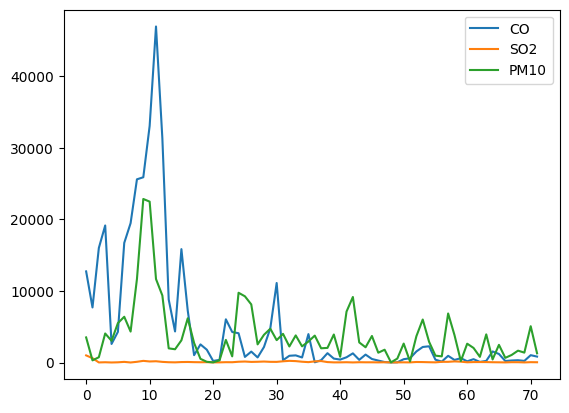

In [88]:
# plot the loss curve
import matplotlib.pyplot as plt
plt.plot(whole_loss1, label='CO', )
plt.plot(whole_loss2, label='SO2')
plt.plot(whole_loss3, label='PM10')

import numpy as np
print(np.mean(whole_loss1))
print(np.mean(whole_loss2))
print(np.mean(whole_loss3))

plt.legend(loc='best')
plt.show()

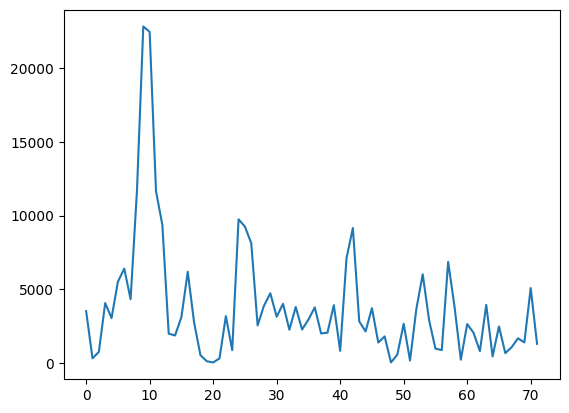

In [89]:
plt.plot(whole_loss3, label='loss')


In [90]:
# calculate MAPE: mean absolute percentage error
def MAPE(y_true, y_pred):
    # print(y_true.shape)
    # print(y_pred.shape)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapes = []
for i in range(72):
    y_true = data[:, i, :].detach().numpy()
    y_pred = y_preds[i].detach().numpy()
    mapes = MAPE(y_true, y_pred)
    
print(np.mean(mapes))


69.96635794639587


torch.Size([9, 72])
torch.Size([9, 72])
tensor(-4.5885)


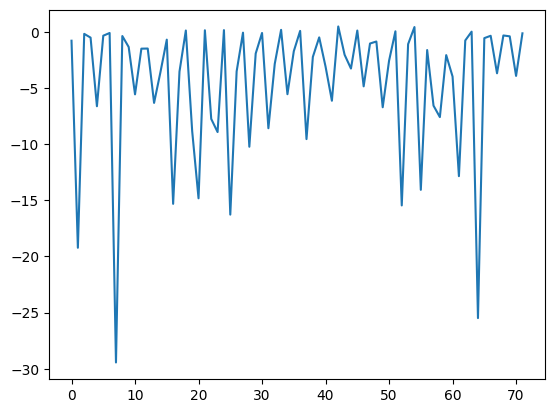

In [91]:
# r2 score
from sklearn.metrics import r2_score
x = data.view(-1, 3, 3)
x = x[1:, :, :]
# print(x.shape)
x = x.view(-1, 72)
print(x.shape)
x = x.detach().numpy()
y = torch.stack(y_preds).view(-1, 72)
print(y.shape)
y = y.detach().numpy()

r2 = torch.zeros(72)
for i in range(72):
    r2[i] = r2_score(x[:, i], y[:, i])

plt.plot(r2, label='r2')
print(sum(r2)/72)